In [1]:
import functions_tunning as ft
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.stats import randint, uniform, loguniform
from skopt.space import Integer, Real, Categorical
import os
import re

In [2]:
dataset_targets = {
    "depression\\depression_transformed.csv": "History of Mental Illness",
    "diabetes\\diabetes_transformed.csv": "diabetes",
    "loan\\loan_transformed.csv": "charged_off",
    "weather\\weather_transformed.csv": "RainTomorrow"
}

In [3]:
X_train0, X_test0, y_train0, y_test0 = ft.load_and_split(list(dataset_targets.keys())[0], dataset_targets[list(dataset_targets.keys())[0]])
X_train1, X_test1, y_train1, y_test1 = ft.load_and_split(list(dataset_targets.keys())[1], dataset_targets[list(dataset_targets.keys())[1]])
X_train2, X_test2, y_train2, y_test2 = ft.load_and_split(list(dataset_targets.keys())[2], dataset_targets[list(dataset_targets.keys())[2]])
X_train3, X_test3, y_train3, y_test3 = ft.load_and_split(list(dataset_targets.keys())[3], dataset_targets[list(dataset_targets.keys())[3]])

## Modele

In [4]:
model1 = XGBClassifier(random_state=42, tree_method = "hist", device = "cuda")
model2 = RandomForestClassifier(random_state=42)
model3 = LogisticRegression(random_state=42)
models = [model1, model2, model3]

### Siatki modeli wraz z uzasadnieniem wyboru

In [5]:
logistic_random_param_grid = [
    {
        'solver': ['lbfgs'],
        'penalty': ['l2'],
        'C': loguniform(1e-3, 1e3),
        'max_iter': randint(1000, 4000)
    },
    {
        'solver': ['saga'],
        'penalty': ['l1', 'l2', 'elasticnet'],
        'l1_ratio': uniform(0.05, 0.9),
        'C': loguniform(1e-3, 1e3),
        'max_iter': randint(1000, 4000)
    }
]

logistic_bayes_param_grid = [
    ({
        'solver': Categorical(['lbfgs']),
        'penalty': Categorical(['l2']),
        'C': Real(1e-3, 1e3, prior='log-uniform'),
        'max_iter': Integer(1000, 4000)
    }, 25),  # liczba prób dla tej przestrzeni
    ({
        'solver': Categorical(['saga']),
        'penalty': Categorical(['l1', 'l2']),
        'C': Real(1e-3, 1e3, prior='log-uniform'),
        'max_iter': Integer(1000, 4000)
    }, 25),
    ({
        'solver': Categorical(['saga']),
        'penalty': Categorical(['elasticnet']),
        'l1_ratio': Real(0.05, 0.9),
        'C': Real(1e-3, 1e3, prior='log-uniform'),
        'max_iter': Integer(1000, 4000)
    }, 25)
]

xgb_random_param_grid = {
    "n_estimators": randint(300, 1200),
    "max_depth": randint(3, 8),
    "learning_rate": loguniform(0.01, 0.1),
    "subsample": uniform(0.6, 0.4),
    "colsample_bytree": uniform(0.6, 0.4),
    "min_child_weight": randint(1, 8),
    "gamma": uniform(0.0, 3.0),
    "reg_lambda": uniform(0.0, 10.0),
    "reg_alpha": uniform(0.0, 5.0),
    "scale_pos_weight": uniform(1.0, 5.0),
}

xgb_bayes_param_grid =  {
    "n_estimators": Integer(300, 1200),
    "max_depth": Integer(3, 8),
    "learning_rate": Real(0.01, 0.1, prior="log-uniform"),
    "subsample": Real(0.6, 1.0),
    "colsample_bytree": Real(0.6, 1.0),
    "min_child_weight": Integer(1, 8),
    "gamma": Real(0.0, 3.0),
    "reg_lambda": Real(0.0, 10.0),
    "reg_alpha": Real(0.0, 5.0),
    "scale_pos_weight": Real(1.0, 5.0)
}

forest_bayes_param_grid = {
    "n_estimators": Integer(10, 200),            # liczba drzew — większa = stabilniejszy model, ale wolniejszy
    "max_depth": Integer(2, 20),                   # głębokość drzewa — zbyt duża = przeuczenie
    "min_samples_split": Integer(2, 8),           # minimalna liczba próbek do podziału węzła
    "min_samples_leaf": Integer(1, 5),             # minimalna liczba próbek w liściu
    "max_features": Categorical(["sqrt", "log2", None]),  # ile cech losować — klasyczne podejścia
    "bootstrap": Categorical([True, False]),       # losowanie z powtórzeniem
    "criterion": Categorical(["gini", "entropy", "log_loss"]),  # funkcja oceny podziału
    "class_weight": Categorical([None, "balanced"]) # balans klas
}

forest_random_param_grid = {
    "n_estimators": randint(10, 200),            # liczba drzew — większa = stabilniejszy model, ale wolniejszy
    "max_depth": randint(2, 20),                   # głębokość drzewa — zbyt duża = przeuczenie
    "min_samples_split": randint(2, 8),           # minimalna liczba próbek do podziału węzła
    "min_samples_leaf": randint(1, 5),             # minimalna liczba próbek w liściu
    "max_features": ["sqrt", "log2", None],  # ile cech losować — klasyczne podejścia
    "bootstrap": [True, False],       # losowanie z powtórzeniem
    "criterion": ["gini", "entropy", "log_loss"],  # funkcja oceny podziału
    "class_weight": [None, "balanced"] # balans klas
}

## Szukanie najlepszych hiperparametrów dla par model - zbiór danych

Wyniki tej części zapisane do plików w folderze 'results_tunning'

In [ ]:
#results_rs1, results_bs1, scores_rs1, full_results_df1 = ft.tune_for_each_data(model1, xgb_random_param_grid, xgb_bayes_param_grid, [X_train0, X_train1, X_train2, X_train3], [y_train0, y_train1, y_train2, y_train3])

dataset_0
Fitting 3 folds for each of 50 candidates, totalling 150 fits
dataset_1
Fitting 3 folds for each of 50 candidates, totalling 150 fits
dataset_2
Fitting 3 folds for each of 50 candidates, totalling 150 fits
dataset_3
Fitting 3 folds for each of 50 candidates, totalling 150 fits


In [ ]:
#results_rs2, results_bs2, scores_rs2, full_results_df2 = ft.tune_for_each_data(model2, forest_random_param_grid, forest_bayes_param_grid, [X_train0, X_train1, X_train2, X_train3], [y_train0, y_train1, y_train2, y_train3])

dataset_0
Fitting 3 folds for each of 50 candidates, totalling 150 fits
dataset_1
Fitting 3 folds for each of 50 candidates, totalling 150 fits
dataset_2
Fitting 3 folds for each of 50 candidates, totalling 150 fits


c:\Users\alapr\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.True_, np.str_('balanced'), np.str_('entropy'), np.int64(20), None, np.int64(5), np.int64(8), np.int64(200)] before, using random point [True, None, 'gini', np.int64(7), 'log2', np.int64(4), np.int64(6), np.int64(82)]
  warnings.warn(
c:\Users\alapr\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.True_, np.str_('balanced'), np.str_('entropy'), np.int64(20), None, np.int64(5), np.int64(8), np.int64(200)] before, using random point [True, None, 'entropy', np.int64(14), 'log2', np.int64(5), np.int64(7), np.int64(23)]
  warnings.warn(
c:\Users\alapr\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.True_, np.str_('balanced'), 

dataset_3
Fitting 3 folds for each of 50 candidates, totalling 150 fits


In [ ]:
#results_rs3, results_bs3, scores_rs3, full_results_df3 = ft.tune_for_each_data(model3, logistic_random_param_grid, logistic_bayes_param_grid, [X_train0, X_train1, X_train2, X_train3], [y_train0, y_train1, y_train2, y_train3])

dataset_0
Fitting 3 folds for each of 50 candidates, totalling 150 fits
dataset_1
Fitting 3 folds for each of 50 candidates, totalling 150 fits
dataset_2
Fitting 3 folds for each of 50 candidates, totalling 150 fits


c:\Users\alapr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


dataset_3
Fitting 3 folds for each of 50 candidates, totalling 150 fits


c:\Users\alapr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\alapr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

## Analiza wyników

In [6]:
datasets = ['Depression', 'Diabetes', 'Loan', 'Weather']

### Wykresy mean_test_score w zależności od iteracji

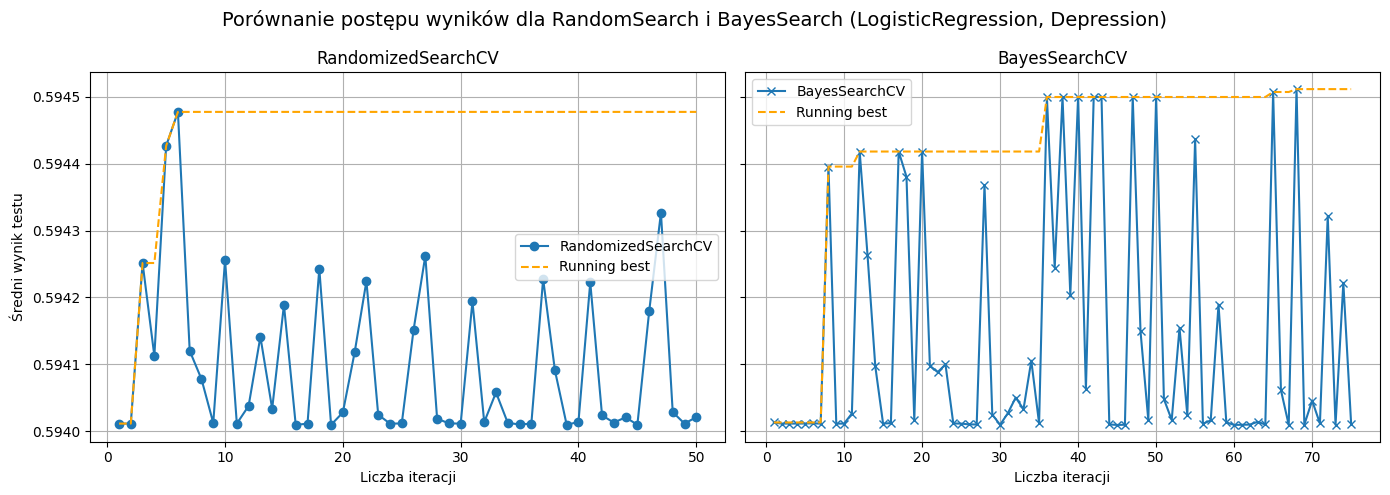

Najlepsze hiperparametry random: {'C': np.float64(0.001102548826429165), 'l1_ratio': np.float64(0.07075618253727418), 'max_iter': 1474, 'penalty': 'elasticnet', 'solver': 'saga'}
Najlepszy wynik random: 0.5944772649432619
Najlepsze hiperparametry bayes: OrderedDict({'C': 0.001, 'l1_ratio': 0.8332849911633243, 'max_iter': 1234, 'penalty': 'elasticnet', 'solver': 'saga'})
Najlepszy wynik bayes: 0.5945113043251634


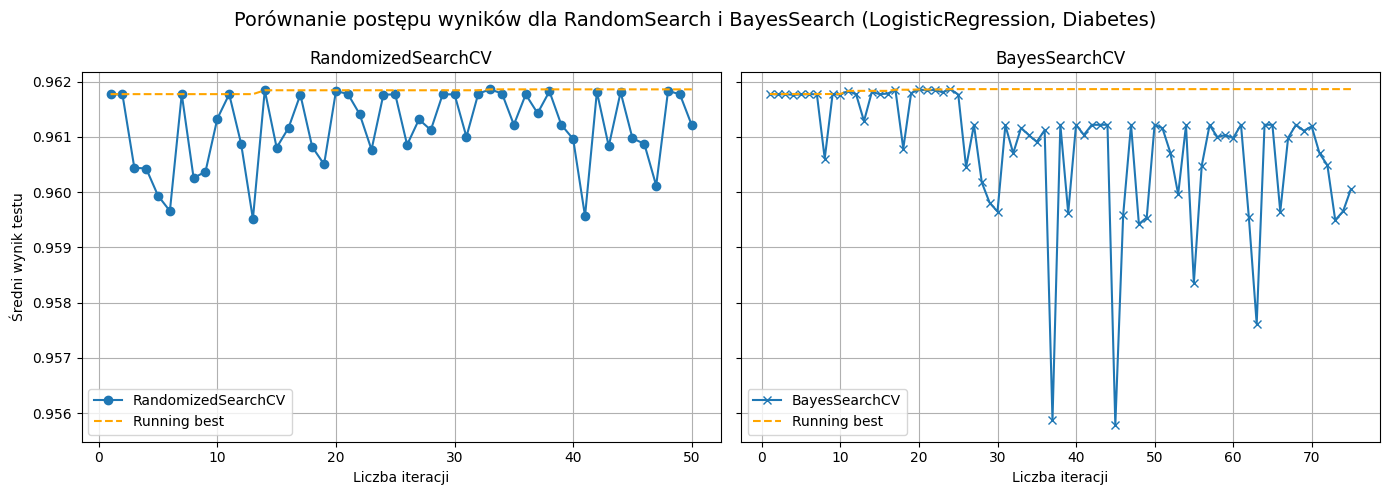

Najlepsze hiperparametry random: {'C': np.float64(0.016229876459045892), 'max_iter': 1863, 'penalty': 'l2', 'solver': 'lbfgs'}
Najlepszy wynik random: 0.9618606845182524
Najlepsze hiperparametry bayes: OrderedDict({'C': 0.016498019365266195, 'max_iter': 3999, 'penalty': 'l2', 'solver': 'lbfgs'})
Najlepszy wynik bayes: 0.9618650565029488


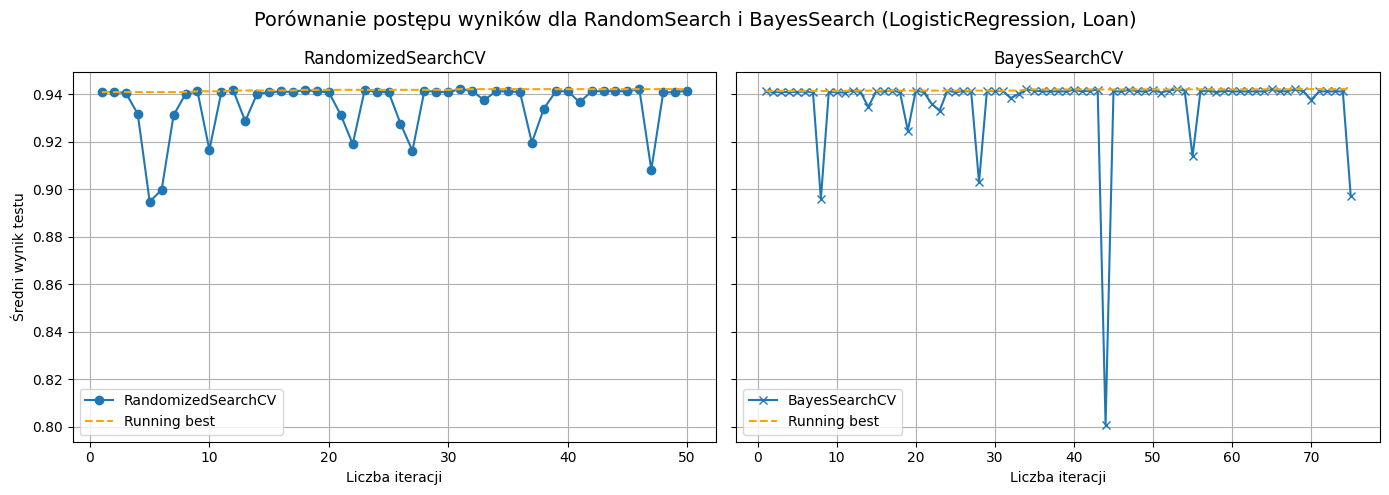

Najlepsze hiperparametry random: {'C': np.float64(0.030287008332244233), 'l1_ratio': np.float64(0.6766738455558096), 'max_iter': 2636, 'penalty': 'l1', 'solver': 'saga'}
Najlepszy wynik random: 0.9420799663721456
Najlepsze hiperparametry bayes: OrderedDict({'C': 0.04551731629996138, 'l1_ratio': 0.9, 'max_iter': 4000, 'penalty': 'elasticnet', 'solver': 'saga'})
Najlepszy wynik bayes: 0.9420900826819302


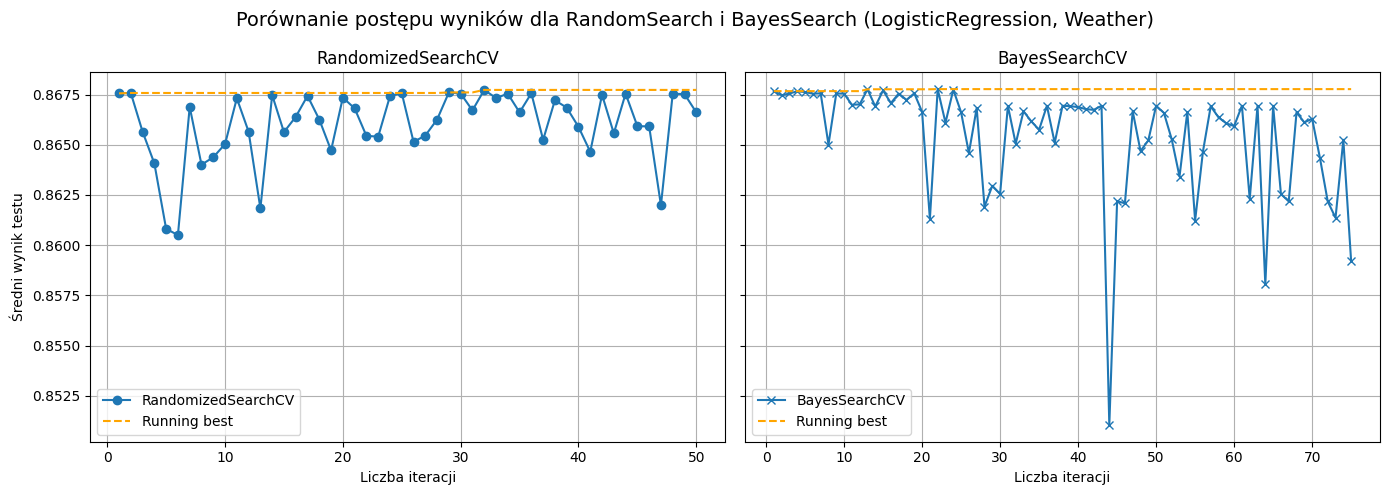

Najlepsze hiperparametry random: {'C': np.float64(0.3674904945305324), 'max_iter': 3939, 'penalty': 'l2', 'solver': 'lbfgs'}
Najlepszy wynik random: 0.867728359649914
Najlepsze hiperparametry bayes: OrderedDict({'C': 982.7569147820517, 'max_iter': 3906, 'penalty': 'l2', 'solver': 'lbfgs'})
Najlepszy wynik bayes: 0.8677676767339761


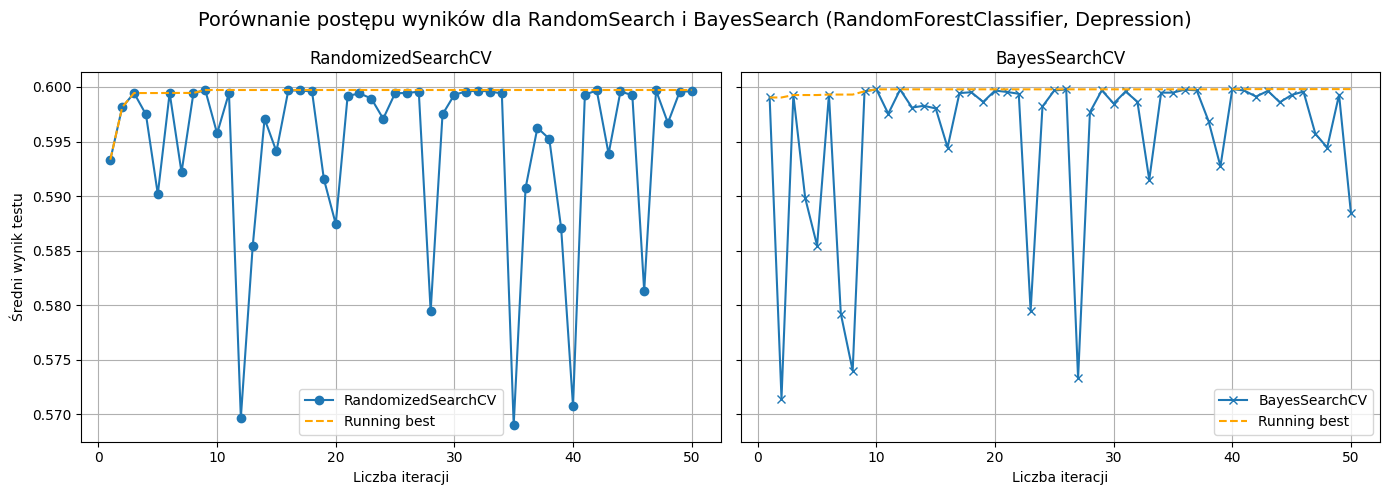

Najlepsze hiperparametry random: {'bootstrap': False, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 7, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 63}
Najlepszy wynik random: 0.5997224955222544
Najlepsze hiperparametry bayes: OrderedDict({'bootstrap': False, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 11})
Najlepszy wynik bayes: 0.5998035520824005


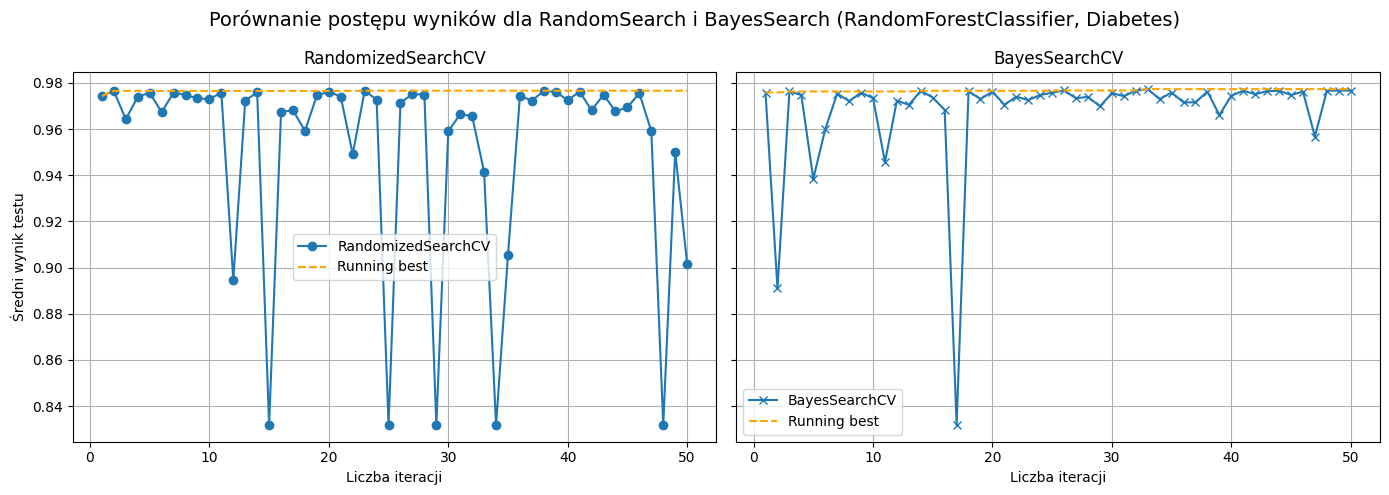

Najlepsze hiperparametry random: {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 12, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 199}
Najlepszy wynik random: 0.9766276982616394
Najlepsze hiperparametry bayes: OrderedDict({'bootstrap': True, 'class_weight': None, 'criterion': 'log_loss', 'max_depth': 12, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 8, 'n_estimators': 200})
Najlepszy wynik bayes: 0.9773099640896546


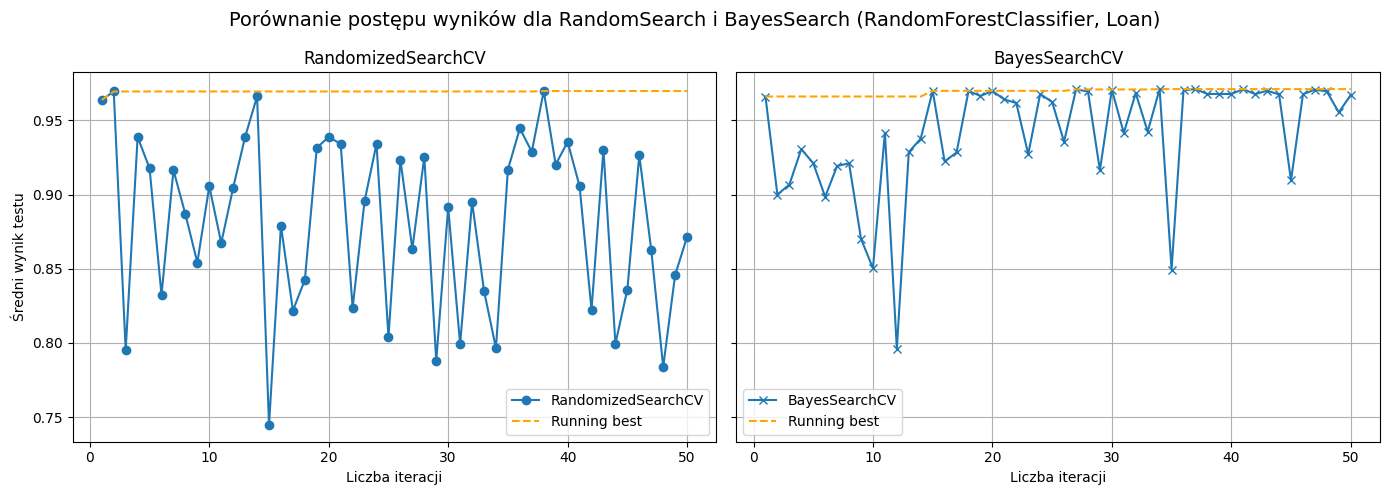

Najlepsze hiperparametry random: {'bootstrap': True, 'class_weight': None, 'criterion': 'log_loss', 'max_depth': 17, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 7, 'n_estimators': 129}
Najlepszy wynik random: 0.969792266158096
Najlepsze hiperparametry bayes: OrderedDict({'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 8, 'n_estimators': 200})
Najlepszy wynik bayes: 0.9710666343279826


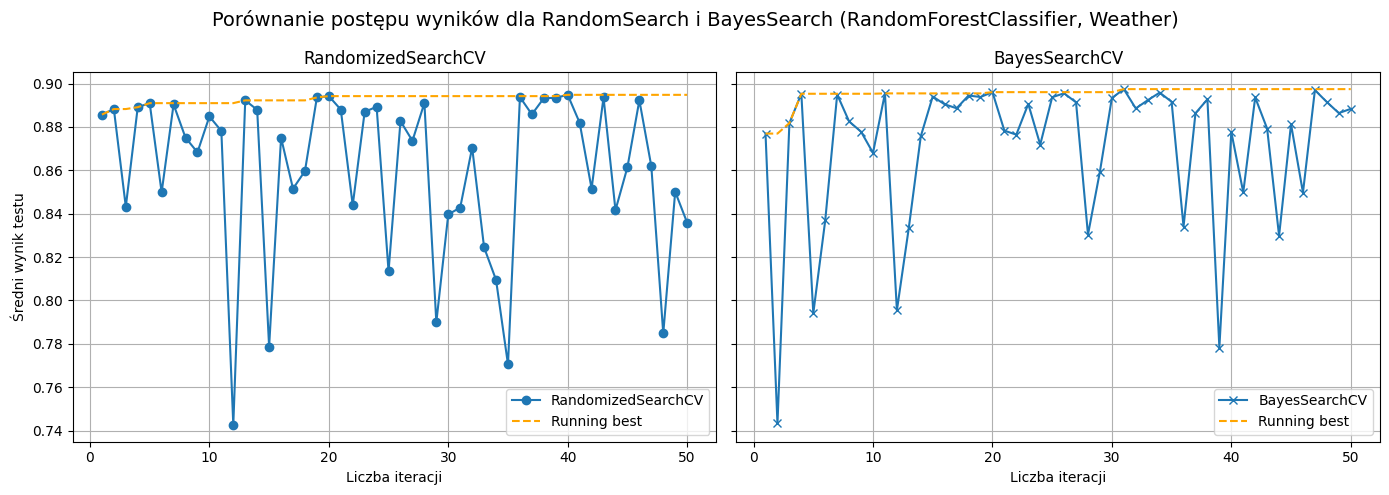

Najlepsze hiperparametry random: {'bootstrap': False, 'class_weight': None, 'criterion': 'log_loss', 'max_depth': 19, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 63}
Najlepszy wynik random: 0.8947987012335966
Najlepsze hiperparametry bayes: OrderedDict({'bootstrap': False, 'class_weight': None, 'criterion': 'log_loss', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200})
Najlepszy wynik bayes: 0.8974349577644395


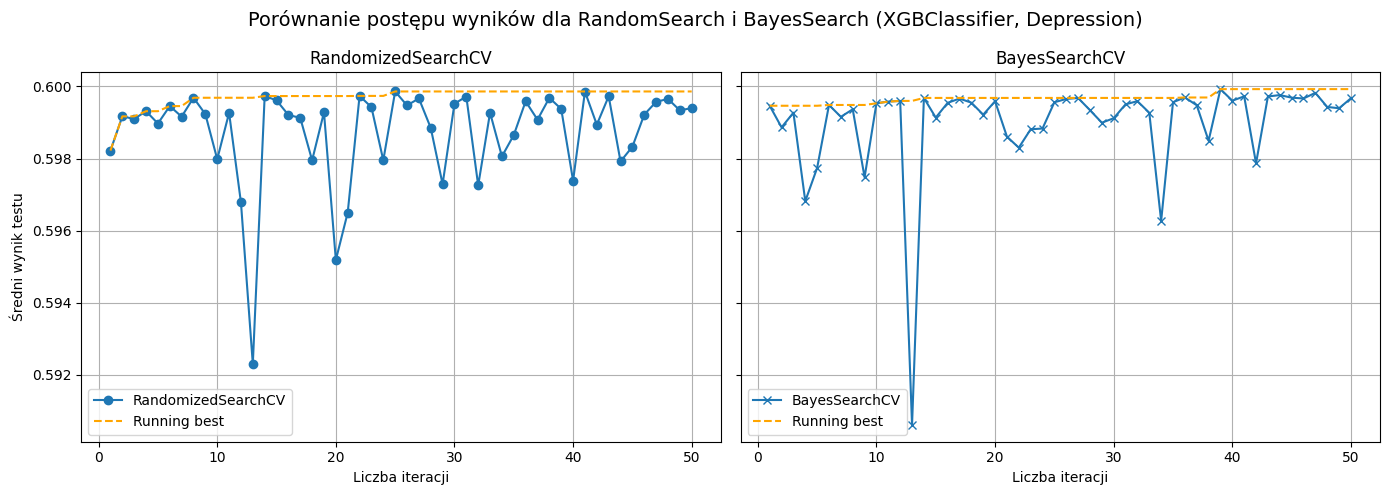

Najlepsze hiperparametry random: {'colsample_bytree': np.float64(0.7465875138331439), 'gamma': np.float64(2.232511569169687), 'learning_rate': np.float64(0.052594450770640004), 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 1182, 'reg_alpha': np.float64(3.1816630909294767), 'reg_lambda': np.float64(2.5046181860558416), 'scale_pos_weight': np.float64(3.9493542378027193), 'subsample': np.float64(0.9915571433100037)}
Najlepszy wynik random: 0.5998603263325376
Najlepsze hiperparametry bayes: OrderedDict({'colsample_bytree': 0.7111210550630757, 'gamma': 0.9499669564931629, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 8, 'n_estimators': 805, 'reg_alpha': 4.233746119318801, 'reg_lambda': 7.879285345319937, 'scale_pos_weight': 3.916532548531401, 'subsample': 1.0})
Najlepszy wynik bayes: 0.5999253156503642


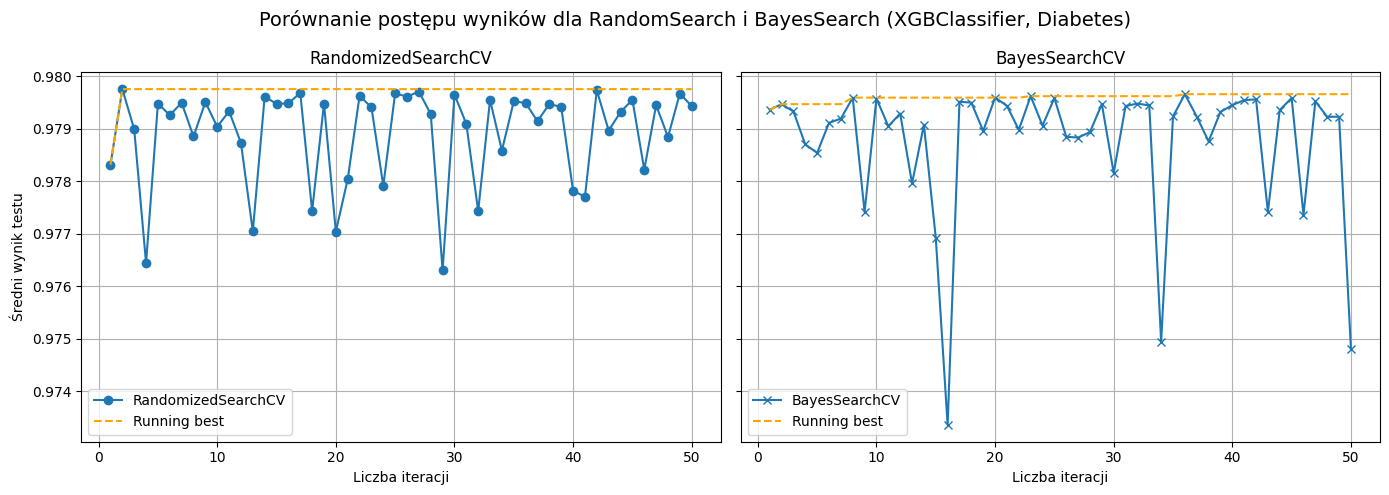

Najlepsze hiperparametry random: {'colsample_bytree': np.float64(0.6571467271687763), 'gamma': np.float64(1.9526654188465586), 'learning_rate': np.float64(0.011387059213756823), 'max_depth': 6, 'min_child_weight': 6, 'n_estimators': 1105, 'reg_alpha': np.float64(0.0038938292050716417), 'reg_lambda': np.float64(9.922115592912174), 'scale_pos_weight': np.float64(4.087407548138582), 'subsample': np.float64(0.8446612641953124)}
Najlepszy wynik random: 0.9797579427827654
Najlepsze hiperparametry bayes: OrderedDict({'colsample_bytree': 0.916517218733089, 'gamma': 2.503898278758046, 'learning_rate': 0.04673720149002265, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 471, 'reg_alpha': 1.4313802415154302, 'reg_lambda': 7.441564665354836, 'scale_pos_weight': 4.952524398170244, 'subsample': 1.0})
Najlepszy wynik bayes: 0.9796616105308384


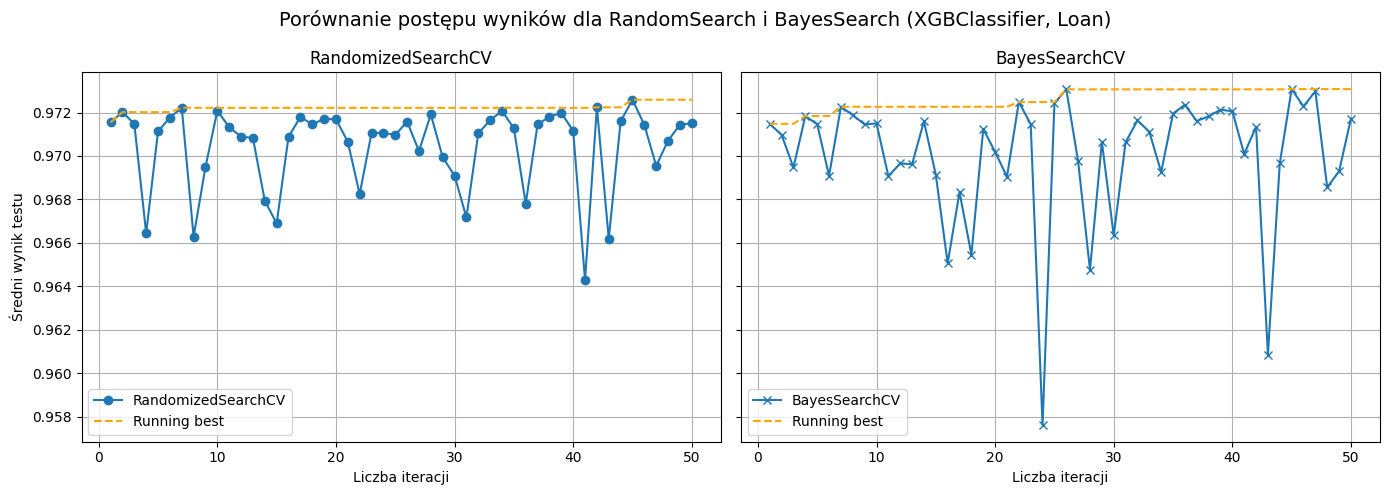

Najlepsze hiperparametry random: {'colsample_bytree': np.float64(0.8137309894122253), 'gamma': np.float64(1.4896835720492332), 'learning_rate': np.float64(0.02452551220584918), 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 318, 'reg_alpha': np.float64(1.9460083936708155), 'reg_lambda': np.float64(0.1083765148029836), 'scale_pos_weight': np.float64(5.5269098820963185), 'subsample': np.float64(0.6365146707144534)}
Najlepszy wynik random: 0.9725896931748128
Najlepsze hiperparametry bayes: OrderedDict({'colsample_bytree': 1.0, 'gamma': 3.0, 'learning_rate': 0.02786530452007804, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 750, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'scale_pos_weight': 5.0, 'subsample': 0.66990478096725})
Najlepszy wynik bayes: 0.9730767409993876


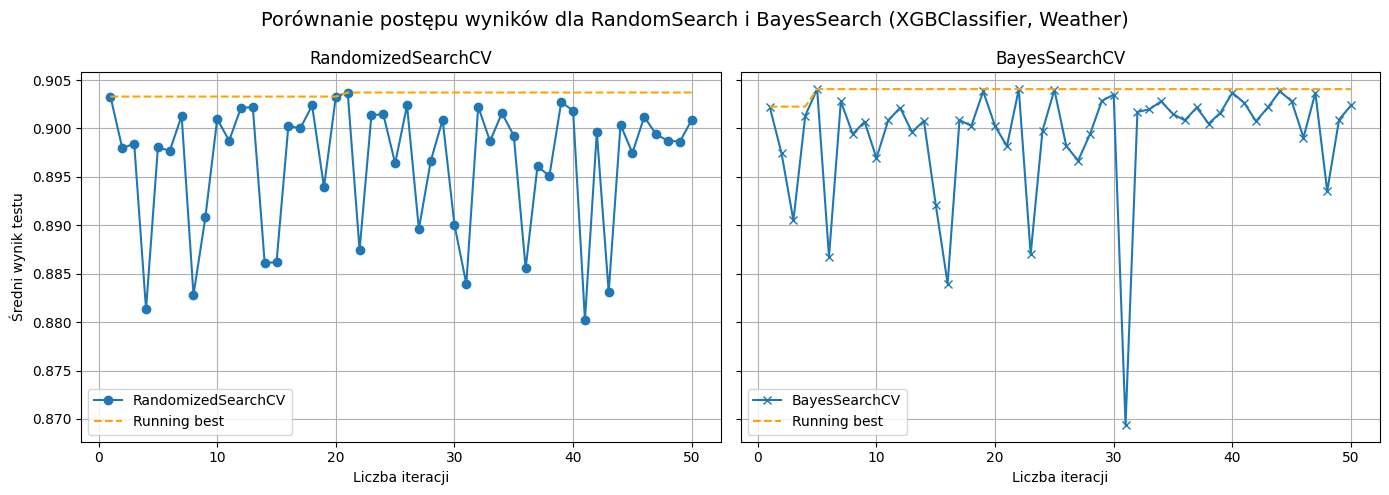

Najlepsze hiperparametry random: {'colsample_bytree': np.float64(0.6836286482950855), 'gamma': np.float64(1.6243439214826974), 'learning_rate': np.float64(0.04963458549101888), 'max_depth': 6, 'min_child_weight': 2, 'n_estimators': 923, 'reg_alpha': np.float64(2.7760040579973118), 'reg_lambda': np.float64(5.296505783560065), 'scale_pos_weight': np.float64(2.2092614545022586), 'subsample': np.float64(0.6372411071223597)}
Najlepszy wynik random: 0.903715996878516
Najlepsze hiperparametry bayes: OrderedDict({'colsample_bytree': 0.9198213766428692, 'gamma': 1.31408755932277, 'learning_rate': 0.033621744005164336, 'max_depth': 7, 'min_child_weight': 7, 'n_estimators': 945, 'reg_alpha': 2.1208903623034105, 'reg_lambda': 6.5028410174776266, 'scale_pos_weight': 2.412335382111886, 'subsample': 0.8637704914796385})
Najlepszy wynik bayes: 0.9040663243932344


In [3]:
pattern = re.compile(r'random_search_results_(\w+)_dataset_(\d+)\.csv')

for filename in os.listdir('results_tunning'):
    results_rs = pd.read_csv(os.path.join('results_tunning', filename))
    if match := pattern.match(filename):
        model_name = match.group(1)
        dataset_num = match.group(2)
        results_bs = pd.read_csv(os.path.join('results_tunning', f'bayes_search_results_{model_name}_dataset_{dataset_num}.csv'))   
        ft.plots_iterations(results_rs, results_bs, model_name, datasets[int(dataset_num)])

Z otrzymanych wykresów możemy odczytać po ilu iteracjach każda z metod znajduje już parametry otrzymujące najlepszy wynik.

### Najlepsze dopasowania

In [7]:
best_params = {}
for model in models:
    for dataset_num in range(len(datasets)):
        model_name, params, score = ft.get_best_result('random',type(model).__name__, dataset_num)
        best_params[(model_name, dataset_num)] = params, score

Dla modelu XGBClassifier i ramki danych 0:
Najlepsze hiperparametry: {'colsample_bytree': np.float64(0.7465875138331439), 'gamma': np.float64(2.232511569169687), 'learning_rate': np.float64(0.052594450770640004), 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 1182, 'reg_alpha': np.float64(3.1816630909294767), 'reg_lambda': np.float64(2.5046181860558416), 'scale_pos_weight': np.float64(3.9493542378027193), 'subsample': np.float64(0.9915571433100037)}
Najlepszy wynik: 0.5998603263325376
Dla modelu XGBClassifier i ramki danych 1:
Najlepsze hiperparametry: {'colsample_bytree': np.float64(0.6571467271687763), 'gamma': np.float64(1.9526654188465586), 'learning_rate': np.float64(0.011387059213756823), 'max_depth': 6, 'min_child_weight': 6, 'n_estimators': 1105, 'reg_alpha': np.float64(0.0038938292050716417), 'reg_lambda': np.float64(9.922115592912174), 'scale_pos_weight': np.float64(4.087407548138582), 'subsample': np.float64(0.8446612641953124)}
Najlepszy wynik: 0.9797579427827654
Dl

In [8]:
best_params_bayes = {}
for model in models:
    for dataset_num in range(len(datasets)):
        model_name, params, score = ft.get_best_result('bayes',type(model).__name__, dataset_num)
        best_params_bayes[(model_name, dataset_num)] = params, score

Dla modelu XGBClassifier i ramki danych 0:
Najlepsze hiperparametry: OrderedDict({'colsample_bytree': 0.7111210550630757, 'gamma': 0.9499669564931629, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 8, 'n_estimators': 805, 'reg_alpha': 4.233746119318801, 'reg_lambda': 7.879285345319937, 'scale_pos_weight': 3.916532548531401, 'subsample': 1.0})
Najlepszy wynik: 0.5999253156503642
Dla modelu XGBClassifier i ramki danych 1:
Najlepsze hiperparametry: OrderedDict({'colsample_bytree': 0.916517218733089, 'gamma': 2.503898278758046, 'learning_rate': 0.04673720149002265, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 471, 'reg_alpha': 1.4313802415154302, 'reg_lambda': 7.441564665354836, 'scale_pos_weight': 4.952524398170244, 'subsample': 1.0})
Najlepszy wynik: 0.9796616105308384
Dla modelu XGBClassifier i ramki danych 2:
Najlepsze hiperparametry: OrderedDict({'colsample_bytree': 1.0, 'gamma': 3.0, 'learning_rate': 0.02786530452007804, 'max_depth': 6, 'min_child_weight': 1, 'n_

## Wyznaczenie uniwersalnych hiperparametrów dla każego modelu

In [9]:
default_params = {}
for model in models:
    model_name = type(model).__name__
    params, score, merged_df = ft.search_default(model_name)
    default_params[model_name] = params, score

Dla modelu XGBClassifier:
Najlepsze hiperparametry domyślne: {'colsample_bytree': np.float64(0.6192235696788134), 'gamma': np.float64(2.847437194774158), 'learning_rate': np.float64(0.07703363425882112), 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 1061, 'reg_alpha': np.float64(4.667181540397415), 'reg_lambda': np.float64(5.010398839152592), 'scale_pos_weight': np.float64(3.6968872420003125), 'subsample': np.float64(0.8735855077592565)}
Najlepszy (średni) wynik domyślny: 0.8633744819108536
Dla modelu RandomForestClassifier:
Najlepsze hiperparametry domyślne: {'bootstrap': True, 'class_weight': None, 'criterion': 'log_loss', 'max_depth': 17, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 7, 'n_estimators': 129}
Najlepszy (średni) wynik domyślny: 0.8586951360842019
Dla modelu LogisticRegression:
Najlepsze hiperparametry domyślne: {'C': np.float64(0.3674904945305324), 'max_iter': 3939, 'penalty': 'l2', 'solver': 'lbfgs'}
Najlepszy (średni) wynik domyślny: 0.84

In [10]:
models_names = [type(model).__name__ for model in models]
models_names

['XGBClassifier', 'RandomForestClassifier', 'LogisticRegression']

## Analiza różnic pomiędzy domyślnymi, a najlepszymi parametrami

TO DO sprawdzić jaka różnica pomiędzy print a wywołaniem funckji

Dla parametrów wyznaczonych za pomoca random search:

In [11]:
import itertools
for i, j in itertools.product(range(len(datasets)), range(len(models_names))):
    b = best_params[(models_names[j], i)]
    d = default_params[models_names[j]]
    print("Dla modelu", models_names[j], "i zbioru danych", datasets[i], ":")
    print("  Najlepsze parametry:", b[0])
    print("  Domyślne parametry:", d[0])
    print(f"Różnica roc_auc: {b[1] - d[1]:.2f}")

Dla modelu XGBClassifier i zbioru danych Depression :
  Najlepsze parametry: {'colsample_bytree': np.float64(0.7465875138331439), 'gamma': np.float64(2.232511569169687), 'learning_rate': np.float64(0.052594450770640004), 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 1182, 'reg_alpha': np.float64(3.1816630909294767), 'reg_lambda': np.float64(2.5046181860558416), 'scale_pos_weight': np.float64(3.9493542378027193), 'subsample': np.float64(0.9915571433100037)}
  Domyślne parametry: {'colsample_bytree': np.float64(0.6192235696788134), 'gamma': np.float64(2.847437194774158), 'learning_rate': np.float64(0.07703363425882112), 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 1061, 'reg_alpha': np.float64(4.667181540397415), 'reg_lambda': np.float64(5.010398839152592), 'scale_pos_weight': np.float64(3.6968872420003125), 'subsample': np.float64(0.8735855077592565)}
Różnica roc_auc: -0.26
Dla modelu RandomForestClassifier i zbioru danych Depression :
  Najlepsze parametry: {'bootstr

Dla paramerów wyznaczonych za pomocą Bayes Search:

In [12]:
import itertools
for i, j in itertools.product(range(len(datasets)), range(len(models_names))):
    b = best_params_bayes[(models_names[j], i)]
    d = default_params[models_names[j]]
    print("Dla modelu", models_names[j], "i zbioru danych", datasets[i], ":")
    print("  Najlepsze parametry:", b[0])
    print("  Domyślne parametry:", d[0])
    print(f"Różnica roc_auc: {b[1] - d[1]:.2f}")

Dla modelu XGBClassifier i zbioru danych Depression :
  Najlepsze parametry: OrderedDict({'colsample_bytree': 0.7111210550630757, 'gamma': 0.9499669564931629, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 8, 'n_estimators': 805, 'reg_alpha': 4.233746119318801, 'reg_lambda': 7.879285345319937, 'scale_pos_weight': 3.916532548531401, 'subsample': 1.0})
  Domyślne parametry: {'colsample_bytree': np.float64(0.6192235696788134), 'gamma': np.float64(2.847437194774158), 'learning_rate': np.float64(0.07703363425882112), 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 1061, 'reg_alpha': np.float64(4.667181540397415), 'reg_lambda': np.float64(5.010398839152592), 'scale_pos_weight': np.float64(3.6968872420003125), 'subsample': np.float64(0.8735855077592565)}
Różnica roc_auc: -0.26
Dla modelu RandomForestClassifier i zbioru danych Depression :
  Najlepsze parametry: OrderedDict({'bootstrap': False, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sq

In [13]:
## Można sprawdzić czy są różnice pomiedzy parametrami z bayes i random oraz czy sa roznice w scorach

Czy funkcja da inne wyniki? Tutaj mamy na nowo trening

In [15]:
default_scores ={}
best_scores ={}
diff_scores = {}
for i in range(len(models)):
    model = models[i]
    #default = to_dict(default_params[models_names[i]][0][1:-1].split(', '))
    list_best_params = []
    list_best_params.extend(
        best_params[models_names[i], j] for j in range(len(datasets))
    )
    df, bst, diff = ft.analyze_tunability(model, [X_train0, X_train1, X_train2, X_train3], [y_train0, y_train1, y_train2, y_train3], list_best_params=list_best_params, default_params=default_params)
    print("Model", models_names[i])
    print('Różnica wyników roc_auc między domyślnymi a najlepszymi parametrami dla ramki:', diff.mean())
    for j in range(len(datasets)):
        print(f"  Zbiór danych {datasets[j]}: {diff[j]}")
    default_scores[models_names[i]] = df
    best_scores[models_names[i]] = bst
    diff_scores[models_names[i]] = diff

<class 'dict'>
{'XGBClassifier': ("{'colsample_bytree': np.float64(0.6192235696788134), 'gamma': np.float64(2.847437194774158), 'learning_rate': np.float64(0.07703363425882112), 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 1061, 'reg_alpha': np.float64(4.667181540397415), 'reg_lambda': np.float64(5.010398839152592), 'scale_pos_weight': np.float64(3.6968872420003125), 'subsample': np.float64(0.8735855077592565)}", np.float64(0.8633744819108536)), 'RandomForestClassifier': ("{'bootstrap': True, 'class_weight': None, 'criterion': 'log_loss', 'max_depth': 17, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 7, 'n_estimators': 129}", np.float64(0.8586951360842019)), 'LogisticRegression': ("{'C': np.float64(0.3674904945305324), 'max_iter': 3939, 'penalty': 'l2', 'solver': 'lbfgs'}", np.float64(0.8412217471421777))}
<class 'tuple'>
("{'colsample_bytree': np.float64(0.7465875138331439), 'gamma': np.float64(2.232511569169687), 'learning_rate': np.float64(0.05259445077

c:\Users\alapr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
c:\Users\alapr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
c:\Users\alapr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


<class 'dict'>
{'XGBClassifier': ("{'colsample_bytree': np.float64(0.6192235696788134), 'gamma': np.float64(2.847437194774158), 'learning_rate': np.float64(0.07703363425882112), 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 1061, 'reg_alpha': np.float64(4.667181540397415), 'reg_lambda': np.float64(5.010398839152592), 'scale_pos_weight': np.float64(3.6968872420003125), 'subsample': np.float64(0.8735855077592565)}", np.float64(0.8633744819108536)), 'RandomForestClassifier': ("{'bootstrap': True, 'class_weight': None, 'criterion': 'log_loss', 'max_depth': 17, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 7, 'n_estimators': 129}", np.float64(0.8586951360842019)), 'LogisticRegression': ("{'C': np.float64(0.3674904945305324), 'max_iter': 3939, 'penalty': 'l2', 'solver': 'lbfgs'}", np.float64(0.8412217471421777))}
<class 'tuple'>
("{'C': np.float64(0.3674904945305324), 'max_iter': 3939, 'penalty': 'l2', 'solver': 'lbfgs'}", np.float64(0.867728359649914))
LogisticR

c:\Users\alapr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\alapr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Model LogisticRegression
Różnica wyników roc_auc między domyślnymi a najlepszymi parametrami dla ramki: 0.0003132047060478427
  Zbiór danych Depression: 0.0004636751163168418
  Zbiór danych Diabetes: 7.129363300606428e-05
  Zbiór danych Loan: 0.0007178500748684646
  Zbiór danych Weather: 0.0


c:\Users\alapr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Heatmap

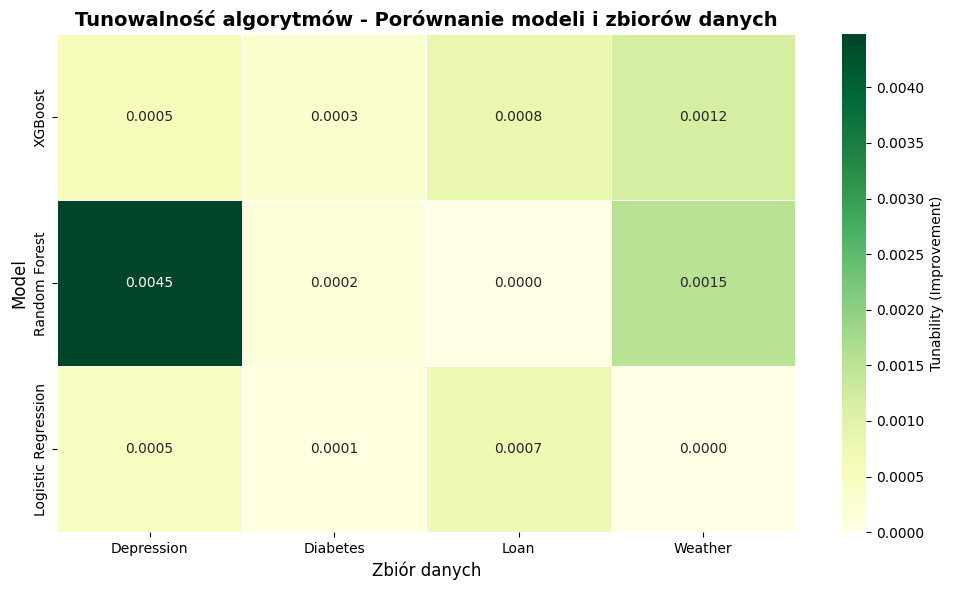

In [16]:
diff_matrix = np.array([diff_scores[models_names[0]], diff_scores[models_names[1]], diff_scores[models_names[2]]])
models = ['XGBoost', 'Random Forest', 'Logistic Regression']
datasets = ['Depression', 'Diabetes', 'Loan', 'Weather']
df_diff = pd.DataFrame(
    diff_matrix,
    index=models,
    columns=datasets
)
plt.figure(figsize=(10, 6))
sns.heatmap(df_diff, annot=True, fmt='.4f', cmap='YlGn', 
            cbar_kws={'label': 'Tunability (Improvement)'}, linewidths=0.5)
plt.title('Tunowalność algorytmów - Porównanie modeli i zbiorów danych', fontsize=14, fontweight='bold')
plt.ylabel('Model', fontsize=12)
plt.xlabel('Zbiór danych', fontsize=12)
plt.tight_layout()
plt.show()

Boxplot

C:\Users\alapr\AppData\Local\Temp\ipykernel_6168\568975667.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([diff_scores[models_names[0]], diff_scores[models_names[1]], diff_scores[models_names[2]]], labels=models)


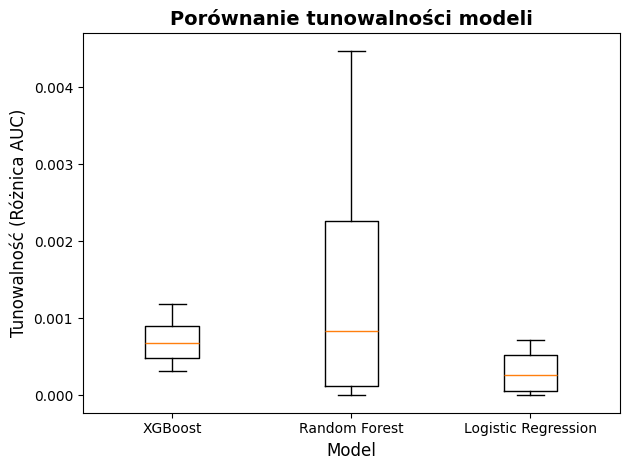

In [18]:
# pass the data as the first positional argument (plt.boxplot expects x as positional)
plt.boxplot([diff_scores[models_names[0]], diff_scores[models_names[1]], diff_scores[models_names[2]]], labels=models)
plt.title('Porównanie tunowalności modeli', fontsize=14, fontweight='bold')
plt.ylabel('Tunowalność (Różnica AUC)', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.tight_layout()
plt.show()

## Analiza wpływu hiperparametrów na wydajność modeli

## Ewaluacja na zbiorach testowych

In [ ]:
## TODO: testowanie na zbiorze testowym, sprawdzenie działania funkcji

In [ ]:
test_auc = {}
reports = {}
for model in models:
    auc, report = ft.evaluate_on_test(models[i], best_params[models_names[i]], [X_train0, X_train1, X_train2, X_train3], [y_train0, y_train1, y_train2, y_train3], [X_test0, X_test1, X_test2, X_test3], [y_test0, y_test1, y_test2, y_test3])
    test_auc[model] = auc
    reports[model] = report